In [1]:
%matplotlib inline
import cv2

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '..'))

from sklearn.externals import joblib
from aye.preprocessing import *
from aye.blob_analyser import *
from aye.detector import Detector

In [2]:
# Load classifier and scaler
clf = joblib.load('../model/svc.pkl')
scaler = joblib.load('../model/scaler.pkl')
detector = Detector(clf, scaler)

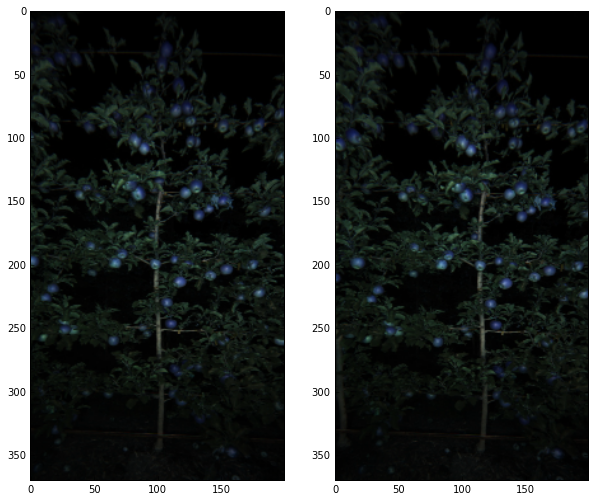

In [126]:
# Load image
im_dir = os.path.join(cwd, 'images')
fig = plt.figure(figsize=(10,10))

bgr1 = cv2.imread(os.path.join(im_dir, 'frame0003.jpg'))
bgr1 = bgr1[200:1000, :1480, :]
bgr1 = rotate_image(bgr1)
s1, im_bw1 = detector.detect(bgr1)

ax = fig.add_subplot(121)
ax.imshow(s1.im_raw, cmap=plt.cm.gray)

bgr2 = cv2.imread(os.path.join(im_dir, 'frame0004.jpg'))
bgr2 = bgr2[200:1000, :1480, :]
bgr2 = rotate_image(bgr2)
s2, im_bw2 = detector.detect(bgr2)

ax = fig.add_subplot(122)
ax.imshow(s2.im_raw, cmap=plt.cm.gray)

In [82]:
# convert to grayscale
gray1 = cv2.cvtColor(s1.im_raw, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(s2.im_raw, cv2.COLOR_BGR2GRAY)

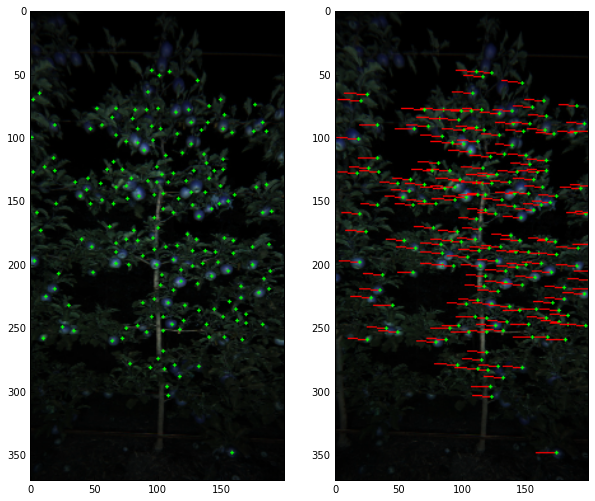

In [122]:
# Method 1: Detect keypoinst in image1 and track to image2
gftt_params = dict(maxCorners = 200,
                   qualityLevel = 0.1,
                   minDistance = 7,
                   blockSize = 7)

klt_params = dict(winSize = (21, 21),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS \
                              | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Detect feature in first image
p1 = cv2.goodFeaturesToTrack(gray1, mask = None, **gftt_params)

# Track into second image
p2, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p1, None, 
                                       **klt_params)

p1_good = p1[st==1]
p2_good = p2[st==1]

# Visualize
disp1 = np.array(s1.im_raw, copy=True)
disp2 = np.array(s2.im_raw, copy=True)
for i, (p1g, p2g) in enumerate(zip(p1_good, p2_good)):
    a, b = p1g.ravel()
    c, d = p2g.ravel()
    
    cv2.line(disp2, (a, b), (c, d), (255, 0, 0), 1)
    cv2.circle(disp2, (c, d), 1, (0, 255, 0), -1)
    cv2.circle(disp1, (a, b), 1, (0, 255, 0), -1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(disp1)

ax = fig.add_subplot(122)
ax.imshow(disp2)

In [101]:
# Need to look at the distribution of all flow vectors
print(p1.shape)
print(p1_good.shape)
print(p1_good[0] - p2_good[0])

(200, 1, 2)
(192, 2)
[-17.37818146  -1.44628143]


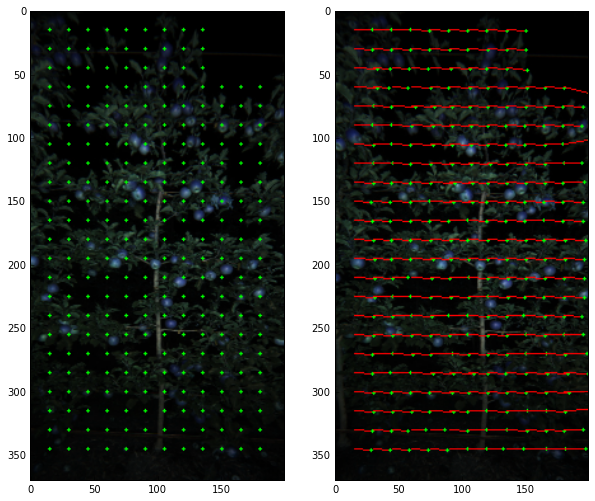

In [125]:
# Method 2: Make a uniform grid of points in image1 and track it to image2
h, w = gray1.shape
step = 15
x = np.arange(step, w - step, step)
y = np.arange(step, h - step, step)
xv, yv = np.meshgrid(x, y)
xv = xv.ravel()
yv = yv.ravel()

p1 = np.vstack((xv, yv)).T
p1 = p1[:, np.newaxis, :]
p1 = np.array(p1, dtype=np.float32)

klt_params = dict(winSize = (21, 21),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS \
                              | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
p2, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p1, None, 
                                       **klt_params)

p1_good = p1[st==1]
p2_good = p2[st==1]
# Visualize

disp1 = np.array(s1.im_raw, copy=True)
disp2 = np.array(s2.im_raw, copy=True)
for i, (p1g, p2g) in enumerate(zip(p1_good, p2_good)):
    a, b = p1g.ravel()
    c, d = p2g.ravel()
    
    cv2.line(disp2, (a, b), (c, d), (255, 0, 0), 1)
    cv2.circle(disp2, (c, d), 1, (0, 255, 0), -1)
    cv2.circle(disp1, (a, b), 1, (0, 255, 0), -1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(disp1)

ax = fig.add_subplot(122)
ax.imshow(disp2)

NameError: name 'clean_bw' is not defined

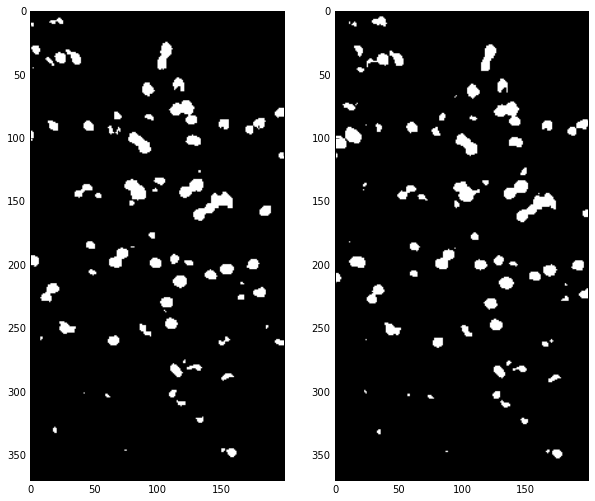

In [129]:
# Method 3: Track the detected points from image1 to image2

# Clean up both images

# Show detection results of both images
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.imshow(im_bw1, cmap=plt.cm.gray)

ax = fig.add_subplot(122)
ax.imshow(im_bw2, cmap=plt.cm.gray)

bw1_clean = clean_bw(im_bw1)
bw2_clean = clean_bw(im_bw2)